# FitzHugh–Nagumo Continuation

This notebook demonstrates how to trace equilibrium branches of the FitzHugh-Nagumo model, a simplified model of neuronal dynamics. A secant-based pseudo-arclength continuation method is used to vary the input current $I$ and map out the bifurcation diagram.

The model consists of a fast voltage variable $v$ and a slow recovery variable $w$:
$$\dot v = v - \tfrac{v^3}{3} - w + I, \qquad \dot w = \tfrac{1}{\tau}(v + a - b w)$$

### Continuation outline:
- Start from a converged equilibrium at an initial current $I_0$.
- Take a small step to $I_1$ to establish an initial tangent for the continuation.
- Use a predictor-corrector scheme: predict the next solution along the secant and correct it using Newton's method on a bordered system.
- Assess the stability of the equilibria by examining the eigenvalues of the Jacobian matrix.
- Visualize the resulting bifurcation branch and sample trajectories.

### Section 1: Imports and Base Parameters
Import necessary libraries and define the model parameters and continuation controls.

In [1]:
import numpy as np
from numpy.linalg import norm, solve, eigvals
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})

# Model parameters (classical excitable regime)
a = 0.7
b = 0.8
tau = 12.5

# Continuation controls
I_start = -0.4
I_step0 = 0.02
I_target = 2.1
max_steps = 4000

# Corrector tolerances
newton_tol = 1e-10
max_newton = 15

# Helper
sign = lambda x: 1.0 if x >= 0 else -1.0

### Section 2: Vector Field and Jacobian
Define the right-hand side of the FitzHugh-Nagumo system and its Jacobian matrix with respect to the state variables, as well as the derivative with respect to the continuation parameter $I$.

In [2]:
def fhn_rhs(vw, I):
    v, w = vw
    return np.array([
        v - (v**3) / 3.0 - w + I,
        (v + a - b * w) / tau,
    ])

def jac_state(vw, I):
    v, w = vw
    return np.array([
        [1.0 - v**2, -1.0],
        [1.0 / tau, -b / tau],
    ])

def df_dI(vw, I):
    # Partial derivative of RHS wrt current I
    return np.array([1.0, 0.0])

### Section 3: Newton Solver for Equilibria
Implement a Newton's method with line search to find the equilibrium points of the system for a fixed value of the input current $I$.

In [3]:
def newton_equilibrium(vw0, I, tol=newton_tol, max_iter=max_newton):
    vw = vw0.copy()
    res = fhn_rhs(vw, I)
    hist = [norm(res, ord=np.inf)]
    for k in range(max_iter):
        if hist[-1] < tol:
            return vw, True, hist
        J = jac_state(vw, I)
        try:
            delta = solve(J, -res)
        except np.linalg.LinAlgError:
            return vw, False, hist

        step = 1.0
        accepted = False
        while step > 1e-6:
            trial = vw + step * delta
            res_trial = fhn_rhs(trial, I)
            if norm(res_trial, ord=np.inf) < hist[-1]:
                vw = trial
                res = res_trial
                hist.append(norm(res, ord=np.inf))
                accepted = True
                break
            step *= 0.5
        if not accepted:
            return vw, False, hist
    return vw, hist[-1] < tol, hist

### Section 4: Bordered System for Pseudo-arclength Correction
Define the augmented residual and Jacobian for the pseudo-arclength continuation. The system is "bordered" with an additional equation that constrains the step to be a fixed arclength distance from the previous solution.

In [4]:
def augmented_residual(z, z_star, tan):
    v, w, I = z
    res_state = fhn_rhs(np.array([v, w]), I)
    return np.array([res_state[0], res_state[1], np.dot(z - z_star, tan)])

def augmented_jacobian(z, tan):
    v, w, I = z
    J_state = jac_state(np.array([v, w]), I)
    dI = df_dI(np.array([v, w]), I)
    J = np.zeros((3, 3))
    J[:2, :2] = J_state
    J[:2, 2] = dI
    J[2, :] = tan
    return J

def newton_augmented(z0, z_star, tan, tol=newton_tol, max_iter=max_newton):
    z = z0.copy()
    res = augmented_residual(z, z_star, tan)
    hist = [norm(res, ord=np.inf)]
    for k in range(max_iter):
        if hist[-1] < tol:
            return z, True, hist
        J = augmented_jacobian(z, tan)
        try:
            delta = solve(J, -res)
        except np.linalg.LinAlgError:
            return z, False, hist

        step = 1.0
        accepted = False
        while step > 1e-6:
            trial = z + step * delta
            res_trial = augmented_residual(trial, z_star, tan)
            if norm(res_trial, ord=np.inf) < hist[-1]:
                z = trial
                res = res_trial
                hist.append(norm(res, ord=np.inf))
                accepted = True
                break
            step *= 0.5
        if not accepted:
            return z, False, hist
    return z, hist[-1] < tol, hist

### Section 5: Pseudo-arclength Continuation Loop
This is the main continuation loop, which iteratively predicts a new solution along the tangent and then corrects it using the augmented Newton solver. The step size `ds` is adapted based on the convergence of the Newton solver.

In [5]:
def continuation(I0=I_start, I1=None, ds0=I_step0, ds_min=1e-3, ds_max=0.2, target=I_target):
    if I1 is None:
        I1 = I0 + ds0

    # Seed point at I0
    vw0, ok0, _ = newton_equilibrium(np.array([-1.0, -1.0]), I0)
    if not ok0:
        raise RuntimeError("Initial equilibrium failed to converge")

    # Second point via natural step in I
    vw1_guess = vw0.copy()
    vw1, ok1, _ = newton_equilibrium(vw1_guess, I1)
    if not ok1:
        raise RuntimeError("Second equilibrium failed; adjust I_step0 or guess")

    branch = [np.hstack([vw0, I0]), np.hstack([vw1, I1])]
    spectra = [eigvals(jac_state(vw0, I0)), eigvals(jac_state(vw1, I1))]
    ds = ds0

    # Direction of continuation in parameter space
    direction = 1.0 if branch[-1][2] >= branch[-2][2] else -1.0

    while len(branch) < max_steps:
        z0 = branch[-2]
        z1 = branch[-1]
        tan = z1 - z0
        tan /= norm(tan)

        z_star = z1 + ds * tan
        z_init = z_star.copy()

        z_new, ok, hist = newton_augmented(z_init, z_star, tan)
        if not ok:
            ds *= 0.5
            if ds < ds_min:
                print("Continuation stalled: step below ds_min")
                break
            continue

        # Check if we reached or crossed the target parameter
        crossed = direction * (z_new[2] - target) >= 0
        if crossed:
            # Linearly interpolate to place a point exactly at target if possible
            denom = z_new[2] - z1[2]
            if abs(denom) > 0:
                alpha = (target - z1[2]) / denom
                if 0.0 <= alpha <= 1.0:
                    z_hit = z1 + alpha * (z_new - z1)
                else:
                    z_hit = z_new
            else:
                z_hit = z_new
            branch.append(z_hit)
            spectra.append(eigvals(jac_state(z_hit[:2], z_hit[2])))
            break

        branch.append(z_new)
        spectra.append(eigvals(jac_state(z_new[:2], z_new[2])))

        # Adaptive step: smaller if many Newton steps, larger if easy
        if len(hist) > 8:
            ds = max(ds * 0.7, ds_min)
        elif len(hist) <= 5:
            ds = min(ds * 1.2, ds_max)

    return np.array(branch), spectra

### Section 6: Run Continuation

In [6]:
branch, spectra = continuation()

vs = branch[:, 0]
ws = branch[:, 1]
Is = branch[:, 2]
stable = np.array([np.max(np.real(s)) < 0 for s in spectra])

print(f"Continuation points: {len(Is)}; I span = [{Is.min():.3f}, {Is.max():.3f}]")
print(f"Stable fraction: {stable.mean()*100:.1f}%")

Continuation points: 37; I span = [-0.400, 2.100]
Stable fraction: 56.8%


### Section 7: Visualize Bifurcation Branch and Sample Trajectories

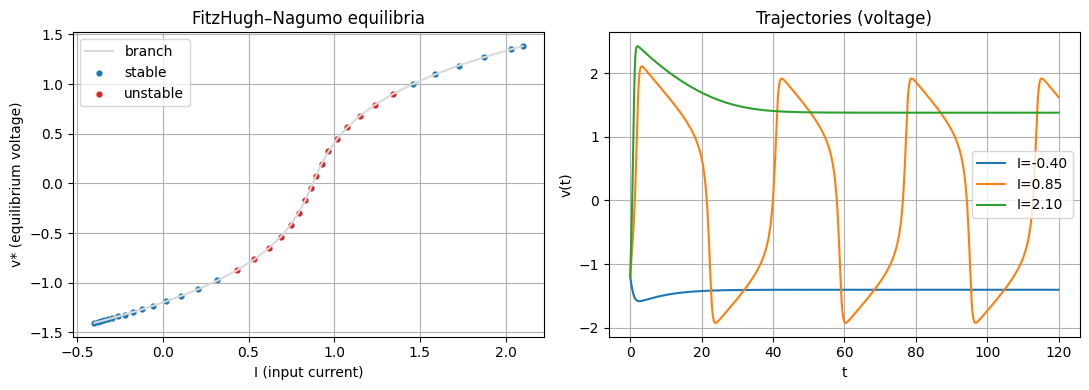

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Branch plot: v* vs I with stability coding
axes[0].plot(Is, vs, color="0.85", lw=1.5, label="branch")
axes[0].scatter(Is[stable], vs[stable], color="tab:blue", s=12, label="stable")
axes[0].scatter(Is[~stable], vs[~stable], color="tab:red", s=12, label="unstable")
axes[0].set_xlabel("I (input current)")
axes[0].set_ylabel("v* (equilibrium voltage)")
axes[0].set_title("FitzHugh–Nagumo equilibria")
axes[0].legend()

# Sample time series for representative I values
sample_I = np.linspace(Is.min(), Is.max(), 3)
t_eval = np.linspace(0, 120, 2000)
for I_val in sample_I:
    def rhs(t, y):
        return fhn_rhs(y, I_val)

    sol = solve_ivp(rhs, [0, t_eval[-1]], y0=[-1.2, -0.6], t_eval=t_eval, rtol=1e-8, atol=1e-9)
    axes[1].plot(sol.t, sol.y[0], label=f"I={I_val:.2f}")

axes[1].set_xlabel("t")
axes[1].set_ylabel("v(t)")
axes[1].set_title("Trajectories (voltage)")
axes[1].legend()
plt.tight_layout()
plt.show()

### Section 8: v-w Phase Portraits
Phase portraits showing the nullclines, a sample trajectory, and the equilibrium point for different values of the input current $I$.

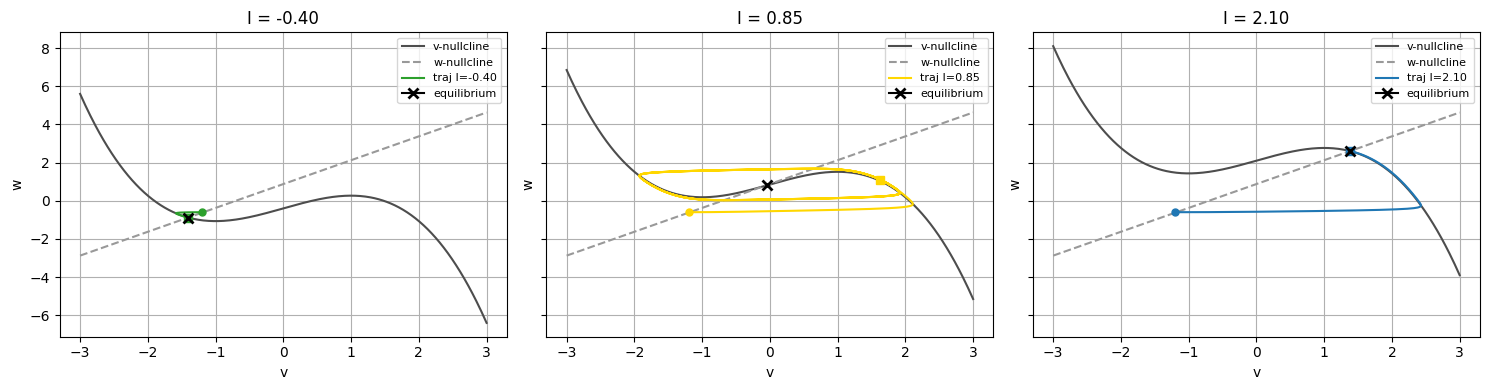

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
colors = ["tab:green", "gold", "tab:blue"]
sample_I = np.linspace(Is.min(), Is.max(), 3)
v_grid = np.linspace(-3, 3, 400)

for ax, I_val, c in zip(axes, sample_I, colors):
    # Nullclines
    w_vnull = v_grid - (v_grid**3) / 3.0 + I_val
    w_wnull = (v_grid + a) / b
    ax.plot(v_grid, w_vnull, color="0.3", lw=1.5, label="v-nullcline")
    ax.plot(v_grid, w_wnull, color="0.6", lw=1.5, linestyle="--", label="w-nullcline")

    # Trajectory for this I
    def rhs(t, y):
        return fhn_rhs(y, I_val)

    sol = solve_ivp(rhs, [0, 120], y0=[-1.2, -0.6], t_eval=np.linspace(0, 120, 2000), rtol=1e-8, atol=1e-9)
    ax.plot(sol.y[0], sol.y[1], color=c, lw=1.5, label=f"traj I={I_val:.2f}")
    ax.plot(sol.y[0, 0], sol.y[1, 0], marker="o", color=c, ms=5)
    ax.plot(sol.y[0, -1], sol.y[1, -1], marker="s", color=c, ms=6)

    # Highlight equilibrium from continuation (closest point in parameter)
    idx = np.argmin(np.abs(Is - I_val))
    ax.plot(vs[idx], ws[idx], marker="x", color="k", ms=7, mew=2, label="equilibrium")

    ax.set_title(f"I = {I_val:.2f}")
    ax.set_xlabel("v")
    ax.set_ylabel("w")
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()